In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from evaluation import get_cm_sklearn, print_metrics
from preprocessing import TrainingPreProcessor

RANDOM_STATE = 0

train_set = pd.read_csv("input/train.csv")

training_preprocessor = TrainingPreProcessor()
training_preprocessor.fit(train_set, ignore_columns=["CLIENTNUM"])

X, y = training_preprocessor.transform(train_set)
class_weight = training_preprocessor.class_weight

### Definição e treinamento do modelo regressão logística

In [2]:
logistic_regression_model = LogisticRegression(
    random_state=RANDOM_STATE, class_weight=class_weight, solver='saga'
)

In [3]:
kfold = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
parameters_l1_l2 = {
    "C": np.logspace(-3, 3, 7),
    "penalty": ["l1", "l2"],
    "max_iter": [1000, 10000],
    "tol": [1e-3, 1e-4, 1e-5],
}
parameters_elasticnet = {
    "C": np.logspace(-3, 3, 7),
    "penalty": ["elasticnet"],
    "max_iter": [1000, 10000],
    "tol": [1e-3, 1e-4, 1e-5],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

In [4]:
grid_search_l1_l2 = GridSearchCV(
    logistic_regression_model,
    parameters_l1_l2,
    scoring="balanced_accuracy",
    cv=kfold,
    verbose=3,
    n_jobs=-1,
)

grid_search_elasticnet = GridSearchCV(
    logistic_regression_model,
    parameters_elasticnet,
    scoring="balanced_accuracy",
    cv=kfold,
    verbose=3,
    n_jobs=-1,
)

In [5]:
grid_search_l1_l2.fit(X, y)
print(grid_search_l1_l2.best_params_)
print(grid_search_l1_l2.best_score_)
grid_search_l1_l2.best_estimator_

Fitting 5 folds for each of 84 candidates, totalling 420 fits
{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001}
0.8496773649266409


LogisticRegression(C=0.1,
                   class_weight={0: 3.1157692307692306, 1: 0.5955741802676077},
                   max_iter=1000, random_state=0, solver='saga')

In [6]:
grid_search_elasticnet.fit(X, y)
print(grid_search_elasticnet.best_params_)
print(grid_search_elasticnet.best_score_)
grid_search_elasticnet.best_estimator_

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
{'C': 0.1, 'l1_ratio': 0.1, 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 0.0001}
0.8495304141551495


LogisticRegression(C=0.1,
                   class_weight={0: 3.1157692307692306, 1: 0.5955741802676077},
                   l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                   random_state=0, solver='saga')

In [7]:
best_model = grid_search_l1_l2.best_estimator_

In [8]:
best_model.fit(X, y)

LogisticRegression(C=0.1,
                   class_weight={0: 3.1157692307692306, 1: 0.5955741802676077},
                   max_iter=1000, random_state=0, solver='saga')

In [9]:
test_set = pd.read_csv("input/test.csv")
X_test, y_test = training_preprocessor.transform(test_set)

### Avaliação do modelo regressão logística

Accuracy: 0.8499506416584403
Balanced Accuracy: 0.8463280253000056
F1: 0.9049405878674172
RoC AuC: 0.8463280253000057


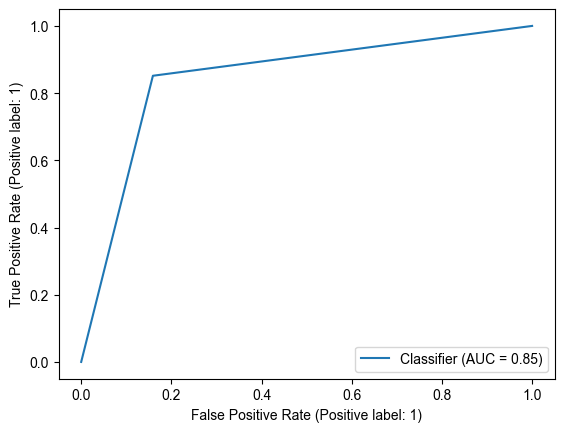

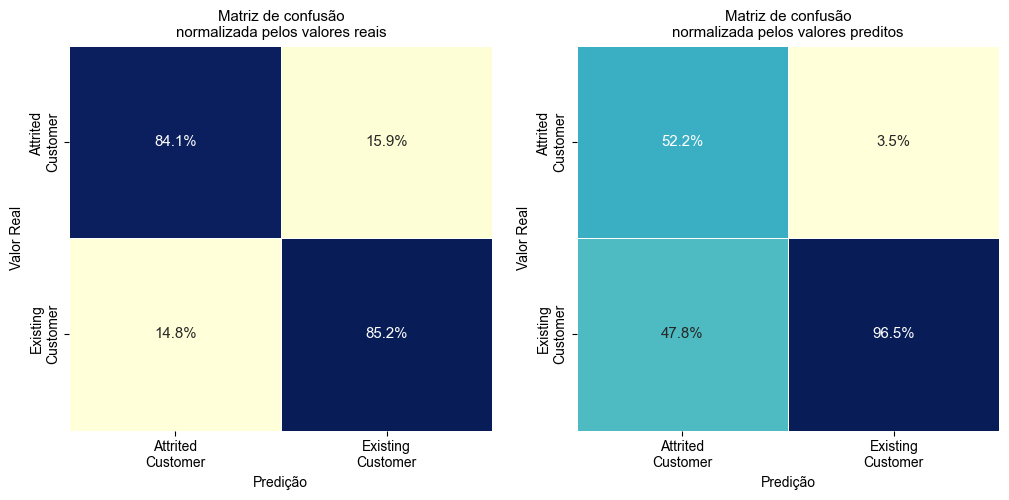

In [10]:
# Avaliação do modelo de Regressão Logística
y_pred_test = best_model.predict(X_test)

print_metrics(y_test, y_pred_test)

get_cm_sklearn(
    y_test,
    y_pred_test,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)